In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_lg
# !pip install bert_score
# !pip install pytorch-pretrained-bert
# !pip install spacy ftfy==4.4.3
# !pip install pytorch_transformers
# !pip install torch==1.3.0
# !pip install keras
!pip install tensorflow

# Load Libraries

In [1]:
from functions import *
from Sentence_ import Sentence_
from Ticket_ import Ticket_
from Ticket_Pair_ import Ticket_Pair_
import pandas as pd

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stopWords = stopwords.words('english')

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from bert_score import score

In [4]:
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/cloud_user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/cloud_user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Dataset

In [5]:

final_to_consider = pd.read_pickle('"-- Set Respective Path HERE --" ')

# Deep Learning Approach

In [6]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.layers.recurrent import GRU

Using TensorFlow backend.


In [7]:
sorted_idx = final_to_consider.ticket_obj.map(lambda x: x.date).sort_values().index
final_to_consider = final_to_consider.loc[sorted_idx]

In [8]:
def clean_text(txt, remove_commas=True):
    
    txt = txt.lower().replace('\n',' ').replace(',',' , ')
    special_characters= set(string.punctuation)
    if not remove_commas:
        special_characters.remove(',')
        
    txt = ''.join(char1 for char1 in txt if char1 not in special_characters)
    num_digits= str.maketrans('','', digits)
    txt = txt.translate(num_digits).strip()
    txt = re.sub(" +", " ", txt)
    return txt

In [9]:
add_marks = lambda x : 'START_ '+ x + ' _END'

In [10]:
source = final_to_consider.ticket_obj.map(lambda x: x.content.text).values.tolist()
# target = final_to_consider.ticket_obj.map(lambda x: x.resolution.text).values.tolist()
target=final_to_consider.res_actions.map(sorted).str.join(',').values.tolist()

In [11]:
source = list(map(lambda x: clean_text(x, True), target))
target = list(map(lambda x: clean_text(x, False), target))
target = list(map(add_marks,target))

In [12]:
max_source_length = max(list(map(lambda x: len(x.split()), source)))
max_target_length = max(list(map(lambda x: len(x.split()), target)))

In [13]:
max_source_length, max_target_length

(309, 331)

In [14]:
# Find all the source and target words and sort them
# Vocabulary of Source language
all_source_words=set()
for source_ in source:
    for word in source_.split():
        if word not in all_source_words:
            all_source_words.add(word)
# Vocabulary of Target 
all_target_words=set()
for target_ in target:
    for word in target_.split():
        if word not in all_target_words:
            all_target_words.add(word)
# sort all unique source and target words
source_words= sorted(list(all_source_words))
target_words=sorted(list(all_target_words))

In [15]:
source_word2idx= dict([(word, i+1) for i,word in enumerate(source_words)])
target_word2idx= dict([(word, i+1) for i,word in enumerate(target_words)])

In [16]:
source_idx2word= dict([(i, word) for word,i in source_word2idx.items()])
target_idx2word= dict([(i, word) for word,i in target_word2idx.items()])

# Split Train/Test Data

In [17]:
final_to_consider.loc[:,'source'] = source
final_to_consider.loc[:,'target'] = target

In [19]:
train_percentage = 0.70
val_percentage = 0.10
test_percentage = 0.20
train_break = int(final_to_consider.shape[0]*train_percentage)
val_break = train_break+int(final_to_consider.shape[0]*val_percentage)

In [21]:
X_train = final_to_consider[:train_break].source.values.tolist()
y_train = final_to_consider[:train_break].target.values.tolist()

X_val = final_to_consider[train_break:val_break].source.values.tolist()
y_val = final_to_consider[train_break:val_break].target.values.tolist()

X_test = final_to_consider[val_break:].source.values.tolist()
y_test = final_to_consider[val_break:].target.values.tolist()

In [22]:
test_df =  final_to_consider[val_break:]

In [23]:
len(X_train), len(X_val), len(X_test)

(11900, 1700, 3400)

In [24]:
# Input tokens for encoder
num_encoder_tokens=len(source_word2idx)+1
# Input tokens for decoder zero padded
num_decoder_tokens=len(target_word2idx)+1

In [25]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = source_word2idx[word] 
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_word2idx[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, target_word2idx[word]] = 1.

            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [26]:
train_samples = len(X_train)
val_samples = len(X_val)
batch_size = 64
epochs = 50
latent_dim=256

## Encoder

In [27]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

## Decoder

In [28]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [29]:
# Define the model that takes encoder and decoder input 
# to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [30]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

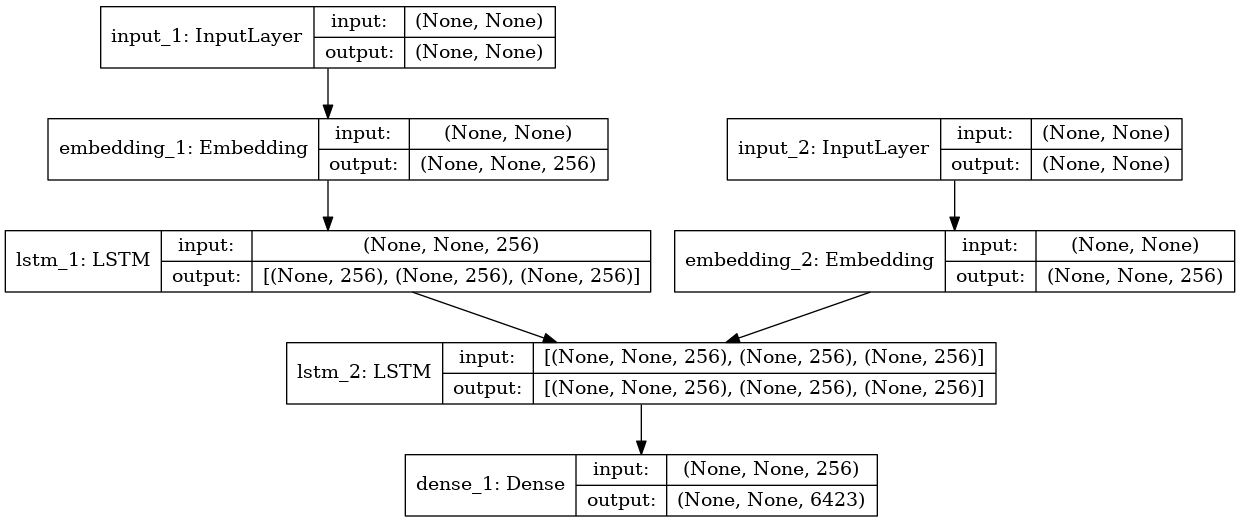

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)

In [33]:
train_samples = len(X_train) # Total Training samples
val_samples = len(X_val)    # Total validation or test samples
batch_size = 64
epochs = 20

In [34]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_val, y_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/20
185/185 [==============================] - 984s 5s/step - loss: 0.1619 - acc: 0.2264 - val_loss: 0.1061 - val_acc: 0.2627
Epoch 2/20
185/185 [==============================] - 866s 5s/step - loss: 0.1299 - acc: 0.3353 - val_loss: 0.1003 - val_acc: 0.3823
Epoch 3/20
185/185 [==============================] - 797s 4s/step - loss: 0.1111 - acc: 0.4386 - val_loss: 0.0863 - val_acc: 0.4620
Epoch 4/20
185/185 [==============================] - 800s 4s/step - loss: 0.0991 - acc: 0.4961 - val_loss: 0.0871 - val_acc: 0.5049
Epoch 5/20
185/185 [==============================] - 812s 4s/step - loss: 0.0901 - acc: 0.5395 - val_loss: 0.1366 - val_acc: 0.5462
Epoch 6/20
185/185 [==============================] - 913s 5s/step - loss: 0.0830 - acc: 0.5728 - val_loss: 0.1028 - val_acc: 0.5795
Epoch 7/20
185/185 [==============================] - 938s 5s/step - loss: 0.0771 - acc: 0.5997 - val_loss: 0.1297 - val_acc: 0.5998
Epoch 8/20
185/185 [==============================] - 858s 5s/step - 

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [87]:
model_history = pd.DataFrame(model.history.history, index=np.arange(1,epochs+1))

In [88]:
model_history.to_pickle('../data/single_lstm_model_history.pkl')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


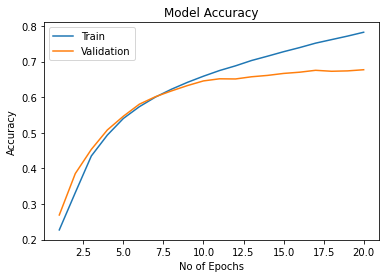

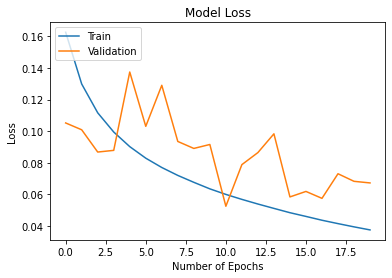

In [79]:
history = model.history
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(np.arange(1, epochs+1).tolist(), history.history['acc'])
plt.plot(np.arange(1, epochs+1).tolist(), history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of Epochs')
# plt.xticks(ticks=[], )
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Inference Model

In [39]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = target_word2idx['START_']
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
# Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or
           len(decoded_sentence) > 100):
            stop_condition = True
# Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return decoded_sentence

In [41]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)

y_preds = []

for i in range(len(y_test)):
    (input_seq, actual_output), _ = next(test_gen)
    decoded_sentence = decode_sequence(input_seq)
    y_preds.append(decoded_sentence)
# print('Input Source sentence:', X_test[k:k+1].values[0])
# print('Actual Target Translation:', y_test[k:k+1].values[0][6:-4])
# print('Predicted Target Translation:', decoded_sentence[:-4])

In [42]:
def split_actions(x):
    x = re.sub('_END|START_', '', x).strip()
    actions = set([a.strip() for a in x.split(',')])
    try:
        actions.remove('')
    except:
        pass
    return list(actions)

In [53]:
test_df.loc[:, 'predicted_actions'] = list(map(split_actions, y_preds))

/home/cloud_user/anaconda3/envs/ticket_resolution/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/cloud_user/anaconda3/envs/ticket_resolution/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
# preds = pd.DataFrame(y_preds, columns=['predicted_actions'])

# preds.to_pickle('../data/dl_preds.pkl')

# """
# Apply actions extractor

# """
# preds = pd.read_pickle('../data/dl_preds.pkl')
# preds.loc[:,'res_actions'] = final_to_consider.res_actions[break_point:].values.tolist()
# test_df = preds

In [54]:
get_spacy_emb = lambda text: nlp(text).vector

In [55]:
def get_neighbors_from_emb(test_vecs, train_vecs, k=5, threshold=0.8):
    
    if (len(test_vecs)==0) or (len(train_vecs)==0):
        return pd.DataFrame(columns=['neighbors'])
    
    test_emb = np.matrix(test_vecs.tolist())
    train_emb = np.matrix(train_vecs.tolist())
    
    similarity = cosine_similarity(test_emb, train_emb)
    neighbors = []
    similarity = np.round(similarity, 2)
    
    for i in range(similarity.shape[0]): 
        states = (similarity[i] >= threshold) & (similarity[0] <= 1)
        indices = np.where(states)[0]
        indices = indices[np.argsort(similarity[i][indices])[::-1][:k]]
        sim_scores = np.round(similarity[i][indices], 4)
        neighbors.append(list(tuple(zip(indices, sim_scores))))
    
    return pd.DataFrame([neighbors], index=['neighbors']).T

In [56]:
# count = 0
def map_best_actions(actual_actions, predicted_actions, res_vectorizer=None):
    global count
    
#     count += 1
    if (len(actual_actions)==0) or (len(predicted_actions)==0):
        return pd.DataFrame()
    
    actual_actions_vecs = np.asarray([get_spacy_emb(action) for action in actual_actions])
    predicted_actions_vecs = np.asarray([get_spacy_emb(action) for action in predicted_actions])
    mapping_ = get_neighbors_from_emb(actual_actions_vecs, predicted_actions_vecs, k=1, threshold=0.0)
    mapping_.index = actual_actions
    mapping_ = mapping_[mapping_.neighbors.map(len)>0]
    
    try:
        mapping_.neighbors = mapping_.neighbors.map(lambda x: (x[0][0], predicted_actions[x[0][0]], x[0][1]))
    except:
        print (actual_actions, predicted_actions)
        print (mapping_)
        raise Exception
    
    return mapping_

# Evaluation of Results

In [57]:
compute_meteor_score = lambda actual, prediction: round(meteor_score([actual], prediction), 4)
compute_bert_scores = lambda actual_list, pred_list : np.round((score(pred_list, actual_list, lang='en', model_type='bert-base-uncased', nthreads=32,rescale_with_baseline=True)[-1]).tolist(),4)


In [58]:
# test_df.loc[:,'predicted_actions'] = test_df.neighbors.apply(lambda x: set(itertools.chain(*[train_df.res_actions.loc[a[0]] for a in x]))).map(list)
test_df.loc[:,'mapped_actions'] = test_df.apply(lambda x: map_best_actions(x['res_actions'],x['predicted_actions'], None), axis=1)


/home/cloud_user/anaconda3/envs/ticket_resolution/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/cloud_user/anaconda3/envs/ticket_resolution/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [59]:
def get_mapped_data(result_df, inc='None'):
    
    if result_df.shape[0] < 1:
        return []
    
    incs = [inc]*result_df.shape[0]
    actual_labels = result_df.index.tolist()
    predicted_labels = result_df.neighbors.map(lambda x: x[1])
    return list(zip(incs, actual_labels, predicted_labels))

# Compute Meteor Score in Bunch 

In [60]:
def generate_best_meteor_scores(df_):
    """ Input : df_['best_actions'] """
    
    df_.loc[:,'best_meteor_scores'] = df_.mapped_actions.apply(lambda r: [compute_meteor_score(res[1],res[2]) for res in get_mapped_data(r)])
    return df_

# Compute BertScore in a Bunch

In [61]:
def generate_best_bert_scores(df_):
    """ Input : df_['best_actions'] """
    
    bert_score_data = df_.apply(lambda x: get_mapped_data(x['mapped_actions'], x.ticket_obj.number) , axis=1)
    bert_score_data = pd.DataFrame(list(itertools.chain(*bert_score_data.values.tolist())), columns=['number','actual','predicted'])
    bert_score_data.loc[:,'bert_score'] = compute_bert_scores(bert_score_data['actual'].values.tolist(), bert_score_data['predicted'].values.tolist())
    bert_score_data.loc[bert_score_data.bert_score<0, 'bert_score'] = 0.0
    bert_score_data.index = bert_score_data.number.values.tolist()
    df_.loc[:,'best_bert_scores'] = df_.ticket_obj.map(lambda x: bert_score_data.bert_score.loc[[x.number]].values.tolist() if x.number in bert_score_data.index else [])
    return df_
    


In [62]:
# test_df.loc[:,'ticket_obj'] = final_to_consider.ticket_obj[11000:].values.tolist()
# test_df

In [63]:
test_df = generate_best_meteor_scores(test_df)
test_df = generate_best_bert_scores(test_df)

In [64]:
test_df.loc[:,'scores_sum'] = test_df.apply(lambda x: (np.mean([x['best_meteor_scores'], x['best_bert_scores']], axis=0).sum()), axis=1) 


In [65]:
test_df.loc[:, 'precision'] = test_df.apply(lambda x: x['scores_sum']/len(x['predicted_actions']) if len(x['predicted_actions'])!=0 else 0, axis=1).values.tolist()
test_df.loc[:, 'recall'] = test_df.apply(lambda x: x['scores_sum']/len(x['res_actions']) if len(x['res_actions'])!=0 else 0, axis=1).values.tolist()
test_df.loc[:, 'precision'] = test_df.precision.map(lambda x: 1.0 if x > 1.0 else x)
test_df.loc[:, 'recall'] = test_df.recall.map(lambda x: 1.0 if x > 1.0 else x)
test_df.loc[:, 'f1_score'] = ((2*test_df['precision']*test_df['recall'])/(test_df['precision']+test_df['recall'])).fillna(0).values.tolist()

In [67]:
""" Encoder Decoder Model """
result = test_df[['precision','recall','f1_score']].describe()

In [69]:
result.to_pickle('../data/lstm_results.pkl')

In [70]:
result

,precision,recall,f1_score
count,3400.000000,3400.000000,3400.000000
mean,0.593515,0.601192,0.594322
std,0.269407,0.261287,0.265037
min,0.000000,0.000000,0.000000
25%,0.435400,0.435400,0.435400
50%,0.563800,0.563800,0.563800
75%,0.871000,0.871000,0.871000
max,1.000000,0.999850,0.999850
